In [5]:
import os
import pandas as pd


# Keras functions
import tensorflow as tf

from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from keras.layers import Activation, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Reshape
from matplotlib import pyplot
from IPython.display import clear_output

# Numpy functions
import numpy
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy import asarray

#Torchvision for fast and easy loading and resizing
import torchvision
import torchvision.transforms as transforms

from PIL import Image


In [18]:
dataset_path = '../Final-Project-main/Art2/kaggle/resized/'
saved_path = '../Final-Project-main/Art2/training_data.npy'

WIDTH = 64
HEIGHT = 64
IMG_SIZE = (WIDTH,HEIGHT)
EPOCHS = 250

#Look for saved file to save time loading and processing images between runs
print("Looking for previously saved file...")

if not os.path.isfile(saved_path):
    print("\n File not found, loading new data...\n")
    dataset = []
    transform_ds = transforms.Compose([transforms.Resize(IMG_SIZE),]) #define transformation
    
    image_folder = torchvision.datasets.ImageFolder(root=dataset_path,
                                     transform=transform_ds)

    print('Number of artworks found: ',len(image_folder))
    
    
    print("Converting images, this will take a few minutes")
    for i in range (len(image_folder)):
        image_array = numpy.array(image_folder[i][0])
        dataset.append(image_array)
        if (i%500 == 0):
            print("Pictures processed: ", i)
            
    print("Saving dataset binary file...")
    dataset = np.array(dataset, dtype=np.float32)
    dataset = (dataset - 127.5) / 127.5 #Normalize to [-1 , 1]
    numpy.save(saved_path, dataset)  #Save processed images as npy file

else:
    print("Data found, loading..")
    dataset = np.load(saved_path) 

print("Dataset length: ", len(dataset))

Looking for previously saved file...

 File not found, loading new data...

Number of artworks found:  8683
Converting images, this will take a few minutes
Pictures processed:  0
Pictures processed:  500
Pictures processed:  1000
Pictures processed:  1500
Pictures processed:  2000
Pictures processed:  2500
Pictures processed:  3000
Pictures processed:  3500
Pictures processed:  4000
Pictures processed:  4500
Pictures processed:  5000
Pictures processed:  5500
Pictures processed:  6000
Pictures processed:  6500
Pictures processed:  7000
Pictures processed:  7500
Pictures processed:  8000
Pictures processed:  8500
Saving dataset binary file...
Dataset length:  8683


In [5]:
dataset = np.load('cubism.npy')

In [7]:
dataset[3].shape

(128, 128, 3)

In [29]:
WIDTH = 128
HEIGHT = 128
IMG_SIZE = (WIDTH,HEIGHT)
EPOCHS = 250

In [30]:
#Use a TensorFlow Dataset to manage the images for easy shuffling, dividing etc
BATCH_SIZE = 32

training_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(9000).batch(BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

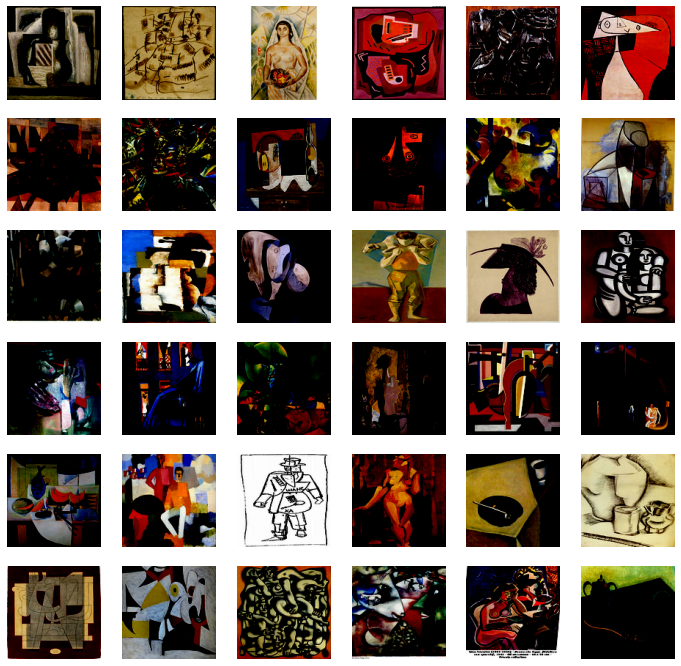

In [31]:
import matplotlib.pyplot as plt
import random

np.random.shuffle(dataset) #Shuffle the images

fig = plt.figure(figsize=(12,12))
for i in range(1,37):
    fig.add_subplot(6,6,i)
    plt.imshow(dataset[i])
    plt.axis('off')

In [105]:
def build_generator(seed_size, channels):
    16384
    model = Sequential()

    model.add(Dense(128*128,activation="relu",input_dim=seed_size)) #64x64 units
    model.add(Reshape((8,8,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Optional additional upsampling goes here
    model.add(UpSampling2D(size = (2,2))) #4,4 for 128x128, 2,2 for 64x64
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))
    
    return model



In [110]:
SEED_SIZE = 100
IMAGE_CHANNELS = 3 # RGB

generator = build_generator(SEED_SIZE,IMAGE_CHANNELS) #If returns model, can do model.save

noise = tf.random.normal([1,SEED_SIZE])
generated_image = generator(noise,training=False)

#plt.imshow(generated_image[0, :, :, 0])

In [114]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [118]:
image_shape = (HEIGHT, HEIGHT, IMAGE_CHANNELS) #None, height, height, RGB? From 1st GAN model

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50001407]], shape=(1, 1), dtype=float32)


In [119]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [120]:
generator_optimizer = tf.keras.optimizers.Adam(1.2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

In [127]:
GENERATED_ROWS = 7
GENERATED_COLS = 7
MARGIN = 2 # Give the images a little frame

def save_images(cnt, noise):
    #Define the "base" of the saved image as a big black canvas
    image_array = np.full(( 
      MARGIN + (GENERATED_ROWS * (WIDTH + MARGIN)), 
      MARGIN + (GENERATED_COLS * (HEIGHT + MARGIN)), 3), 
      0, dtype=np.uint8)
    
    generated_images =  generator.predict(noise)
    
    image_count = 0
    for row in range(GENERATED_ROWS):
        for col in range(GENERATED_COLS):
            r = row * (WIDTH + 2) + MARGIN
            c = col * (HEIGHT + 2) + MARGIN
            image_array[r:r+WIDTH , c:c+HEIGHT] = generated_images[image_count] * 127.5 + 127.5
            image_count += 1
            
    output_path  = os.path.join('Art2/Output2')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

In [128]:
# This goes a bit deeper "behind the scenes" and manually sets the gradients
# instead of letting Keras and TensorFlow set it automatically. This is because
# the two models need to be trained separately
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training = True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        
        gradients_of_generator = gen_tape.gradient(
            gen_loss,
            generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss, 
            discriminator.trainable_variables
        )
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                generator.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                    discriminator.trainable_variables))
        
        return gen_loss, disc_loss

In [129]:
def train(dataset, epochs):
    # Use a fixed seed for the saved images so we can watch their development
    fixed_seed = np.random.normal(0, 1, (GENERATED_ROWS * GENERATED_COLS, SEED_SIZE))
    
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            
        g_loss = sum(gen_loss_list) / len(gen_loss_list) #calculate losses
        d_loss = sum(disc_loss_list) / len(disc_loss_list)
        
        # Save the model every 25 epochs
        if (epoch) % 25 == 0:
            generator.save(f'GAN-{epoch}')
        
        print(f'Epoch {epoch+1}, gen loss = {g_loss}, disc loss = {d_loss}')
        
        save_images(epoch, fixed_seed)
        

In [130]:
train(training_dataset, EPOCHS)

INFO:tensorflow:Assets written to: GAN-0/assets
Epoch 1, gen loss = 2.090226411819458, disc loss = 1.5357725620269775
Epoch 2, gen loss = 3.6849277019500732, disc loss = 1.1983058452606201
Epoch 3, gen loss = 4.3378472328186035, disc loss = 0.8992778658866882
Epoch 4, gen loss = 2.92283296585083, disc loss = 1.812743902206421
Epoch 5, gen loss = 2.08223032951355, disc loss = 1.5213000774383545
Epoch 6, gen loss = 2.511176824569702, disc loss = 1.6027450561523438
Epoch 7, gen loss = 2.2194020748138428, disc loss = 1.3755817413330078
Epoch 8, gen loss = 1.5082433223724365, disc loss = 1.8201724290847778
Epoch 9, gen loss = 1.3447145223617554, disc loss = 1.6406062841415405
Epoch 10, gen loss = 1.8155229091644287, disc loss = 1.5455199480056763
Epoch 11, gen loss = 1.5310381650924683, disc loss = 1.7735729217529297
Epoch 12, gen loss = 1.7345198392868042, disc loss = 1.4992420673370361
Epoch 13, gen loss = 1.795458197593689, disc loss = 1.7752653360366821
Epoch 14, gen loss = 1.5241817235

Epoch 113, gen loss = 2.3168981075286865, disc loss = 0.9002336859703064
Epoch 114, gen loss = 2.4177300930023193, disc loss = 0.9764687418937683
Epoch 115, gen loss = 2.43601393699646, disc loss = 0.9871817231178284
Epoch 116, gen loss = 2.296051502227783, disc loss = 1.0227320194244385
Epoch 117, gen loss = 2.0426769256591797, disc loss = 1.0737417936325073
Epoch 118, gen loss = 2.197600841522217, disc loss = 0.9122146368026733
Epoch 119, gen loss = 2.369429588317871, disc loss = 0.9159335494041443
Epoch 120, gen loss = 2.5870361328125, disc loss = 0.9747101664543152
Epoch 121, gen loss = 2.506847381591797, disc loss = 0.8853154182434082
Epoch 122, gen loss = 2.4103071689605713, disc loss = 0.8900780081748962
Epoch 123, gen loss = 2.4330289363861084, disc loss = 0.8720248937606812
Epoch 124, gen loss = 2.4325218200683594, disc loss = 0.9076793789863586
Epoch 125, gen loss = 2.5996029376983643, disc loss = 0.9685195684432983
INFO:tensorflow:Assets written to: GAN-125/assets
Epoch 126,

Epoch 224, gen loss = 4.000742435455322, disc loss = 0.533390462398529
Epoch 225, gen loss = 3.818753480911255, disc loss = 0.5716824531555176
INFO:tensorflow:Assets written to: GAN-225/assets
Epoch 226, gen loss = 3.930988073348999, disc loss = 0.6550233960151672
Epoch 227, gen loss = 4.059305667877197, disc loss = 0.5366798639297485
Epoch 228, gen loss = 4.0190300941467285, disc loss = 0.5590174198150635
Epoch 229, gen loss = 3.8888566493988037, disc loss = 0.5607636570930481
Epoch 230, gen loss = 3.9843029975891113, disc loss = 0.5393452048301697
Epoch 231, gen loss = 4.026055335998535, disc loss = 0.5561845302581787
Epoch 232, gen loss = 3.851874589920044, disc loss = 0.5691694617271423
Epoch 233, gen loss = 3.953625440597534, disc loss = 0.5477520227432251
Epoch 234, gen loss = 3.9987897872924805, disc loss = 0.5165989398956299
Epoch 235, gen loss = 4.041069984436035, disc loss = 0.49318182468414307
Epoch 236, gen loss = 3.973311185836792, disc loss = 0.552529513835907
Epoch 237, 

In [132]:
generator.save('Art2/Model 2/')

INFO:tensorflow:Assets written to: Art2/Model 2/assets


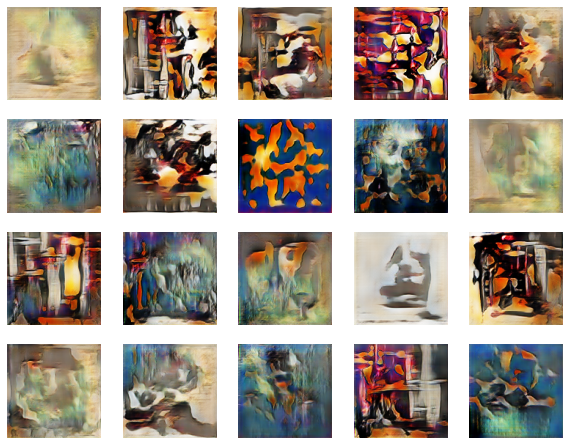

In [131]:
seed2 = tf.random.normal([BATCH_SIZE, SEED_SIZE])
generated_images2 = generator(seed2, training = True)

generated_images2 =0.5 * generated_images2 + 0.5

fig = plt.figure(figsize=(10,10))
for i in range(1,21):
    fig.add_subplot(5,5,i)
    plt.imshow(generated_images2[i])
    plt.axis('off')

In [ ]:
##### IMAGE GENERATOR ####

In [ ]:
from tensorflow import keras
from skimage.transform import resize

model = keras.models.load_model('Art2/Model 2/')

In [ ]:
seed2 = tf.random.normal([32, 100])
generated_images2 = model(seed2, training = True)

In [ ]:
bottle_resized = resize(generated_images2[4], (480, 512))

In [ ]:
tf.keras.preprocessing.image.array_to_img(
    bottle_resized, data_format=None, scale=True, dtype=None
)